In [3]:
import torch
import torch.nn as nn
import numpy as np

### 建立block

In [4]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu1 = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out

### 建立layer

In [5]:
def make_layers(in_channels, layer_list):
    layers = []
    for out_channels in layer_list:
      layers += [Block(in_channels, out_channels)]
      in_channels = out_channels
    return nn.Sequential(*layers)
            

class Layer(nn.Module):
    def __init__(self, in_channels, layer_list):
        super(Layer, self).__init__()
        self.layer = make_layers(in_channels, layer_list)
    def forward(self, x):
        out = self.layer(x)
        return out

### 建立VGG-19BN模型

* 'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
* 'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
* 'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
* 'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],

In [6]:
class VGG_fcn32s(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, n_class=21):
        super(VGG_fcn32s, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=100)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = Layer(64, [64])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = Layer(64, [128, 128])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = Layer(128, [256, 256, 256, 256])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = Layer(256, [512, 512, 512, 512])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = Layer(512, [512, 512, 512, 512])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # modify to be compatible with segmentation and classification
        #self.fc6 = nn.Linear(512*7*7, 4096)
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout()

        #self.fc7 = nn.Linear(4096, 4096)
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout()

        #self.score = nn.Linear(4096, n_class)
        self.score = nn.Conv2d(4096, n_class, 1)
        
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, 32)

    def forward(self, x):
        f0 = self.relu1(self.bn1(self.conv1(x)))
        f1 = self.pool1(self.layer1(f0))
        f2 = self.pool2(self.layer2(f1))
        f3 = self.pool3(self.layer3(f2))
        f4 = self.pool4(self.layer4(f3))
        f5 = self.pool5(self.layer5(f4))
        #f5 = f5.view(f5.size(0), -1)
        print(f5.shape)
        f6 = self.drop6(self.relu6(self.fc6(f5)))
        print(f6.shape)
        f7 = self.drop7(self.relu7(self.fc7(f6)))
        print(f7.shape)
        score = self.score(f7)
        upscore = self.upscore(score)
        upscore = upscore[:, :, 19:19+x.size(2), 19:19+x.size(3)].contiguous()
        return upscore

vgg_model = VGG_fcn32s()
x = torch.randn((2, 3, 190, 190), dtype=torch.float32)
y = vgg_model(x)
print(y.shape)

torch.Size([2, 512, 12, 12])
torch.Size([2, 4096, 6, 6])
torch.Size([2, 4096, 6, 6])
torch.Size([2, 21, 190, 190])


### 上采样模块的权重初始化

In [7]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    
    center = kernel_size / 2 - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

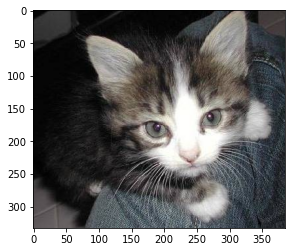

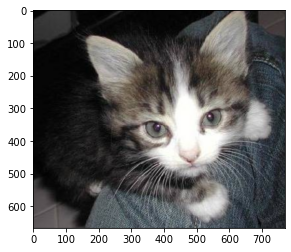

In [16]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
x = plt.imread('cat.png')
x_torch = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
# channels, bias ?
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1, groups=3, bias=False)
conv_trans.weight.data = bilinear_kernel(3, 1, 4)
#print(conv_trans.weight)
y_torch = conv_trans(x_torch)
y = y_torch.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

#x = x.astype(np.uint8)
#print(x.shape)
plt.imshow( x)
plt.show()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#y = y.astype(np.uint8)
#print(y.shape)
plt.imshow(y)
plt.show()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### 建立VGG_19bn_8s模型

In [17]:
class VGG_19bn_8s(nn.Module):
    def __init__(self, n_class=21):
        super(VGG_19bn_8s, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=100)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = Layer(64, [64])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = Layer(64, [128, 128])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = Layer(128, [256, 256, 256, 256])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = Layer(256, [512, 512, 512, 512])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = Layer(512, [512, 512, 512, 512])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc6 = nn.Conv2d(512, 4096, 7) # padding=0
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.trans_f4 = nn.Conv2d(512, n_class, 1)
        self.trans_f3 = nn.Conv2d(256, n_class, 1)

        self.up2times = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up4times = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up32times = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data = bilinear_kernel(n_class, n_class, m.kernel_size[0])
    
    def forward(self, x):
        f0 = self.relu1(self.bn1(self.conv1(x)))
        f1 = self.pool1(self.layer1(f0))
        f2 = self.pool2(self.layer2(f1))
        f3 = self.pool3(self.layer3(f2))
        f4 = self.pool4(self.layer4(f3))
        f5 = self.pool5(self.layer5(f4))
        
        f6 = self.drop6(self.relu6(self.fc6(f5)))
        f7 = self.score_fr(self.drop7(self.relu7(self.fc7(f6))))
        
        up2_feat = self.up2times(f7)
        h = self.trans_f4(f4)
        print(h.shape)
        print(up2_feat.shape)
        h = h[:, :, 5:5 + up2_feat.size(2), 5:5 + up2_feat.size(3)]
        h = h + up2_feat
        
        up4_feat = self.up4times(h)
        h = self.trans_f3(f3)
        print(h.shape)
        print(up4_feat.shape)
        h = h[:, :, 9:9 + up4_feat.size(2), 9:9 + up4_feat.size(3)]
        h = h + up4_feat
        
        h = self.up32times(h)
        print(h.shape)
        final_scores = h[:, :, 31:31 + x.size(2), 31:31 + x.size(3)].contiguous()
        
        return final_scores

In [18]:
model = VGG_19bn_8s(21)
x = torch.randn(2, 3, 58, 58)
model.eval()
y_vgg = model(x)
y_vgg.size()

torch.Size([2, 21, 16, 16])
torch.Size([2, 21, 6, 6])
torch.Size([2, 21, 32, 32])
torch.Size([2, 21, 14, 14])
torch.Size([2, 21, 120, 120])


torch.Size([2, 21, 58, 58])

In [19]:
from torchsummary import summary
summary(model, (3, 224, 224))

torch.Size([2, 21, 26, 26])
torch.Size([2, 21, 16, 16])
torch.Size([2, 21, 52, 52])
torch.Size([2, 21, 34, 34])
torch.Size([2, 21, 280, 280])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 422, 422]           1,792
       BatchNorm2d-2         [-1, 64, 422, 422]             128
              ReLU-3         [-1, 64, 422, 422]               0
            Conv2d-4         [-1, 64, 422, 422]          36,928
       BatchNorm2d-5         [-1, 64, 422, 422]             128
              ReLU-6         [-1, 64, 422, 422]               0
             Block-7         [-1, 64, 422, 422]               0
             Layer-8         [-1, 64, 422, 422]               0
         MaxPool2d-9         [-1, 64, 211, 211]               0
           Conv2d-10        [-1, 128, 211, 211]          73,856
      BatchNorm2d-11        [-1, 128, 211, 211]             256
             ReLU-12     

## offset和crop的计算

设输入图的一边长为h,padding=100
前向传播过程中图像大小经过n此下采样的计算公式：
$out=[(h+2padding-k)/stride+1]/2^n$<br/>
1.计算每层输出的大小：<br/>
layer1:$[out1=(h+200-3)/1+1]/2^1=(h+198)/2^1$<br/>
layer2:$[out2=(h+200-3)/1+1]/2^2=(h+198)/2^2$<br/>
layer3:$[out3=(h+200-3)/1+1]/2^3=(h+198)/2^3$<br/>
layer4:$[out4=(h+200-3)/1+1]/2^4=(h+198)/2^4$<br/>
layer5:${[out5=(h+200-7)/1+1]/2^5}-7+1=(h+6)/2^5$<br/>

2.计算FCN-4s网络<br/>
上采样图像大小计算公式：$out=(I-1)stride+k-2padding$<br/>
经过上采样每层的大小(最后下采样的大小为$(h+6)/2^5$)：<br/>
2倍：layer6:$out6=((h+6)/2^5-1)2+4=(h+38)/2^4$<br/>
4倍：layer7:$out7=((h+38)/2^4-1)2+4=(h+54)/2^3$<br/>
8倍：layer8:$out8=((h+54)/2^3-1)2+4=(h+62)/2^2$<br/>
32倍：layer10:$out6=((h+62)/2^2-1)4+8=h+66$<br/>

3.计算crop和offset<br/>
2倍上采样的crop:$\delta_1=(h+198)/2^4-(h+38)/2^4=10,crop=\delta_1/2=5$<br/>
4倍上采样的crop:$\delta_2=(h+198)/2^3-(h+54)/2^3=18,crop=\delta_2/2=9$<br/>
8倍上采样的crop:$\delta_3=(h+198)/2^2-(h+62)/2^2=34,crop=\delta_3/2=17$<br/>
32倍上采样的crop:$\delta_1=66,crop=\delta_1/2=33$<br/>

In [37]:
class VGG_19bn_4s(nn.Module):
    def __init__(self, n_class=21):
        super(VGG_19bn_4s, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=100)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = Layer(64, [64])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = Layer(64, [128, 128])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = Layer(128, [256, 256, 256, 256])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer4 = Layer(256, [512, 512, 512, 512])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = Layer(512, [512, 512, 512, 512])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc6 = nn.Conv2d(512, 4096, 7) # padding=0
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.trans_f4 = nn.Conv2d(512, n_class, 1)
        self.trans_f3 = nn.Conv2d(256, n_class, 1)
        self.trans_f2 = nn.Conv2d(128, n_class, 1)

        self.up2times = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up4times = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up8times = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.up32times = nn.ConvTranspose2d(
            n_class, n_class, 8, stride=4, bias=False)
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data = bilinear_kernel(n_class, n_class, m.kernel_size[0])
    
    def forward(self, x):
        f0 = self.relu1(self.bn1(self.conv1(x)))
        f1 = self.pool1(self.layer1(f0))
        f2 = self.pool2(self.layer2(f1))
        f3 = self.pool3(self.layer3(f2))
        f4 = self.pool4(self.layer4(f3))
        f5 = self.pool5(self.layer5(f4))
        
        f6 = self.drop6(self.relu6(self.fc6(f5)))
        f7 = self.score_fr(self.drop7(self.relu7(self.fc7(f6))))
        
        up2_feat = self.up2times(f7)
        h = self.trans_f4(f4)

        h = h[:, :, 5:5 + up2_feat.size(2), 5:5 + up2_feat.size(3)]
        h = h + up2_feat
        
        up4_feat = self.up4times(h)
        h = self.trans_f3(f3)

        h = h[:, :, 9:9 + up4_feat.size(2), 9:9 + up4_feat.size(3)]
        h = h + up4_feat
        
        up8_feat = self.up8times(h)
        h = self.trans_f2(f2)

        h = h[:, :, 17:17 + up8_feat.size(2), 17:17 + up8_feat.size(3)]

        h = h + up8_feat
        
        h = self.up32times(h)
        final_scores = h[:, :, 33:33 + x.size(2), 33:33 + x.size(3)].contiguous()
        
        return final_scores
    

In [38]:
vgg_model = VGG_19bn_4s()
x = torch.randn((2, 3, 58, 58), dtype=torch.float32)
y = vgg_model(x)
print(y.shape)

torch.Size([2, 21, 58, 58])
